<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/barley_seed_shape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 大麦種子形状解析

## ライセンス

## 解説

〜〜では、otsu法やwatershedなど、基本的な画像解析手法を用いてイネ種子の計数と形状解析を行いました。

## 備考

## 環境構築

本稿では深層学習のフレームワークにONNXを使用します。colaboratoryではONNX推論エンジンであるonnxruntime (gpu対応の場合はonnxruntime-gpu)がプレインストールされていないため、pipでインストールする必要があります。しかしながら、2023年12月現在、colaboratoryの環境はubuntu 22.04にCUDA12.2がインストールされている一方、最新版であるonnxruntime-gpu==1.16はCUDA11.6~11.8にしか対応していません。従ってGPU推論を行いたい場合、下のコードセルを実行し、CUDAをダウングレードします。ただし、実行にある程度の時間がかかるため、飛ばしてもかまいません。（その場合、自動的にCPU推論に切り替わります）

In [1]:
# CUDA11.8へのダウングレード
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda-repo-ubuntu2204-11-8-local_11.8.0-520.61.05-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu2204-11-8-local_11.8.0-520.61.05-1_amd64.deb
!sudo cp /var/cuda-repo-ubuntu2204-11-8-local/cuda-*-keyring.gpg /usr/share/keyrings/
!sudo apt-get update
!sudo apt-get -y install cuda-11-8

#途中で国やキーボード構成を聞かれることがありますが、その場合は
# 1つ目は　Country of origin for the keyboard: が表示されたら、その右側の空白をクリックして55を入力し、enter
# ２つ目はKeyBoard Layoutの右側に1を入力し、enter

--2023-12-24 20:26:53--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2204.pin’

cuda-ubuntu2204.pin 100%[===================>]     190  --.-KB/s    in 0s      

2023-12-24 20:26:53 (12.4 MB/s) - ‘cuda-ubuntu2204.pin’ saved [190/190]

--2023-12-24 20:26:53--  https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda-repo-ubuntu2204-11-8-local_11.8.0-520.61.05-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 O

In [2]:
!pip install -q onnxruntime-gpu==1.16
!git clone https://github.com/matterport/Mask_RCNN.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.0 MB/s eta 0:00:00
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 35.64 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [3]:
import sys
sys.path.append("Mask_RCNN")

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

import mrcnn
from mrcnn import utils, visualize, config

公式レポジトリのMaskRCNN classより、必要な前処理、後処理のコード部分を単離します。mrcnnのmodel.pyにはkeras1由来のプログラムコードによりインポートエラーが起きるため、model.pyにある関数・クラスはノートブックに記述しなおします。

In [4]:
def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

def compute_backbone_shapes(config, image_shape):
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

def get_anchors(image_shape, config):
    """Returns anchor pyramid for the given image size."""
    backbone_shapes = compute_backbone_shapes(config, image_shape)
    _anchor_cache = {}
    a = utils.generate_pyramid_anchors(
        config.RPN_ANCHOR_SCALES,
        config.RPN_ANCHOR_RATIOS,
        backbone_shapes,
        config.BACKBONE_STRIDES,
        config.RPN_ANCHOR_STRIDE)
    anchors = a
    _anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
    return _anchor_cache[tuple(image_shape)]

def prepare_inputs(image, config):
    molded_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    molded_image = molded_image.astype(np.float32) - config.MEAN_PIXEL

    image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([config.NUM_CLASSES], dtype=np.int32))

    image_shape = molded_image.shape
    anchors = get_anchors(image_shape, config)
    anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

    molded_images = np.expand_dims(molded_image,axis=0)
    molded_images = molded_images.astype(np.float32)
    image_metas = np.array([image_meta],dtype=np.float32)
    windows = np.array([window])
    return molded_images, image_metas, anchors, windows

def unmold_detections(detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1
        ww = wx2 - wx1
        scale = np.array([wh, ww, wh, ww])
        boxes = np.divide(boxes - shift, scale)
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]
        full_masks = []
        for i in range(N):
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))
        return boxes, class_ids, scores, full_masks

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import onnxruntime as ort
print("Available providers:", ort.get_available_providers())

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']


## Mask-RCNN

In [7]:
model_path = "/content/drive/MyDrive/barley_maskrcnn/model_weights/barley_maskrcnn.onnx"
providers = [
    'CUDAExecutionProvider', 'CPUExecutionProvider' \
    if "CUDAExecutionProvider" in ort.get_available_providers() \
    else ['CPUExecutionProvider']
    ]
ort_session = ort.InferenceSession(model_path, providers=providers)
print(ort_session.get_providers())

input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

['CUDAExecutionProvider', 'CPUExecutionProvider']
Input names: ['input_image', 'input_image_meta', 'input_anchors']
Output names: ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox']


In [8]:
class InferenceConfig(config.Config):
    NAME = "seed"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + 1 seeds

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 8192
    IMAGE_RESIZE_MODE = "pad64"

    DETECTION_MAX_INSTANCES = 1000
    RPN_NMS_THRESHOLD = 0.4
    DETECTION_MIN_CONFIDENCE = 0

    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

In [9]:
!ls /content/drive/MyDrive/barley_maskrcnn/realworld_test/image/

B669.jpg  C346.jpg  E245.jpg  H602.jpg	I335.jpg  I626.jpg  J247.jpg  K692.jpg	N009.jpg  U051.jpg
C319.jpg  C656.jpg  E612.jpg  I304.jpg	I622.jpg  J064.jpg  J647.jpg  K735.jpg	T567.jpg  U353.jpg


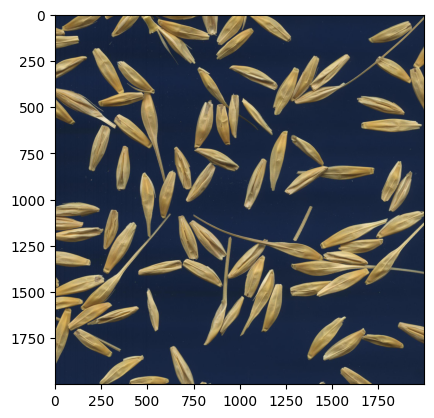

In [10]:
image = cv2.imread("/content/drive/MyDrive/barley_maskrcnn/realworld_test/image/B669.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [11]:
config = InferenceConfig()
# 画像を読み込み、configをもとにメタデータ、アンカー、ウィンドウなど推論に必要な情報を生成します。
molded_images, image_metas, anchors, windows = prepare_inputs(image, config)

In [12]:
#cpu推論の場合数分必要
predictions = ort_session.run(
    ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox'],
    {"input_image": molded_images,
     "input_image_meta": image_metas,
     "input_anchors": anchors})

In [13]:
#['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox']
print(len(predictions[0]))

1


In [14]:
# 出力結果のうち、mrcnn_detectionとmrcnn_maskしか使わない。
detections = predictions[0]
mrcnn_mask = predictions[3]

results = []
final_rois, final_class_ids, final_scores, final_masks =\
    unmold_detections(detections[0], mrcnn_mask[0],
                            image.shape, molded_images[0].shape,
                            windows[0])
results.append({
    "rois": final_rois,
    "class_ids": final_class_ids,
    "scores": final_scores,
    "masks": final_masks,
})
r = results[0]

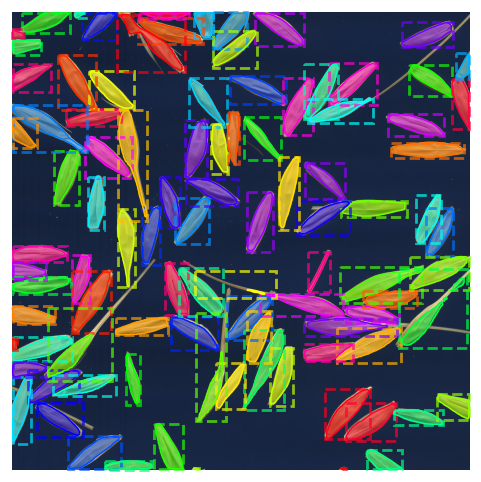

In [15]:
visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            ["",""], ["" for x in range(len(r['scores']))],  # ラベル名や検出確率は空白にします
            show_bbox=True, show_mask=True,
            figsize=(6,6))

## 形状解析

推論結果の後処理から得られたr["masks"]には、検出された物体１つ１つのmask画像が格納されています。
これらをskimage.measureのlabel, regionpropsで形状解析すれば種子の形を求めることができます。(形状抽出の方法については他ノートブックで詳しく解説しているので省略します。)

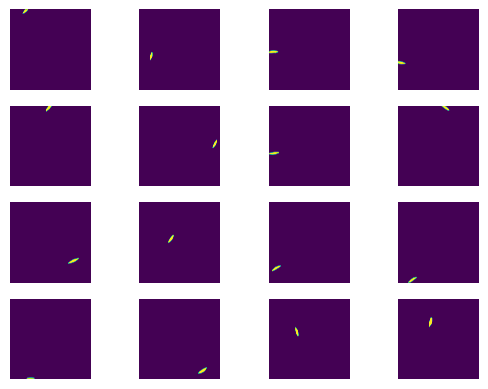

In [16]:
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(r["masks"][..., i])
    plt.axis("off")

それではデータセットディレクトリにある画像を解析してみましょう。
１画像につき、１品種の種子の画像が含まれています。
まずはどのようなファイルがあるか確認します。

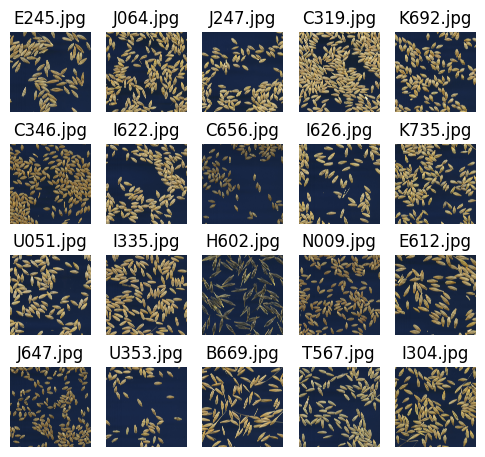

In [43]:
DATASET_DIR = "/content/drive/MyDrive/barley_maskrcnn/realworld_test/image"
files = os.listdir(DATASET_DIR)

plt.figure(figsize=(6,7))
for i, file in enumerate(files):
    path = os.path.join(DATASET_DIR, file)
    image = cv2.imread(path)[...,::-1]
    plt.subplot(5,5, i+1)
    plt.imshow(image)
    plt.title(file)
    plt.axis("off")
plt.subplots_adjust()

In [21]:
from skimage.measure import label, regionprops
import os

def extract_features(mask):
    lbl = label(mask)
    props = regionprops(lbl)
    # get the largest area label
    idx = np.argmax([x.area for x in props])
    prop = props[idx]
    return prop.area, prop.axis_minor_length, prop.axis_major_length

def predict(path):
    config = InferenceConfig()

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    molded_images, image_metas, anchors, windows = prepare_inputs(image, config)
    predictions = ort_session.run(
        ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox'],
        {"input_image": molded_images,
        "input_image_meta": image_metas,
        "input_anchors": anchors})
    detections = predictions[0]
    mrcnn_mask = predictions[3]

    results = []
    final_rois, final_class_ids, final_scores, final_masks =\
        unmold_detections(detections[0], mrcnn_mask[0],
                                image.shape, molded_images[0].shape,
                                windows[0])
    results.append({
        "rois": final_rois,
        "class_ids": final_class_ids,
        "scores": final_scores,
        "masks": final_masks,
    })
    r = results[0]
    return r["masks"]

results = []

for file in files[:3]:
    path = os.path.join(DATASET_DIR, file)
    masks = predict(path)
    masks = masks.transpose(2,0,1)
    for mask in masks:
        area, width, length = extract_features(mask)
        results.append([file, area, width, length])

In [26]:
import pandas as pd

df = pd.DataFrame(results, columns=["cultivar","area","width","height"])

# 外れ値の除去
def remove_outliers(group):
    for column in ['area', 'width', 'height']:
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        group = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
    return group

df = df.groupby('cultivar').apply(remove_outliers).reset_index(drop=True)

df

,cultivar,area,width,height
0,E245.jpg,11860,77.077081,198.608612
1,E245.jpg,11225,66.008303,220.765290
2,E245.jpg,12602,72.545954,223.161645
3,E245.jpg,15049,78.639845,244.568632
4,E245.jpg,13057,74.847151,225.483687
...,...,...,...,...
281,J247.jpg,9661,66.960484,185.756715
282,J247.jpg,7614,63.179350,155.645622
283,J247.jpg,7201,53.185432,179.517404
284,J247.jpg,6442,59.595731,141.358358


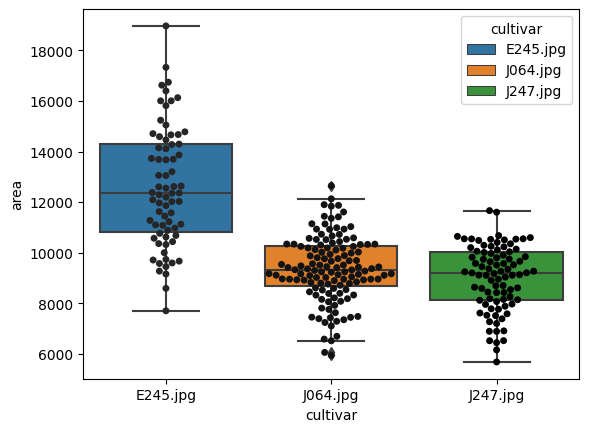

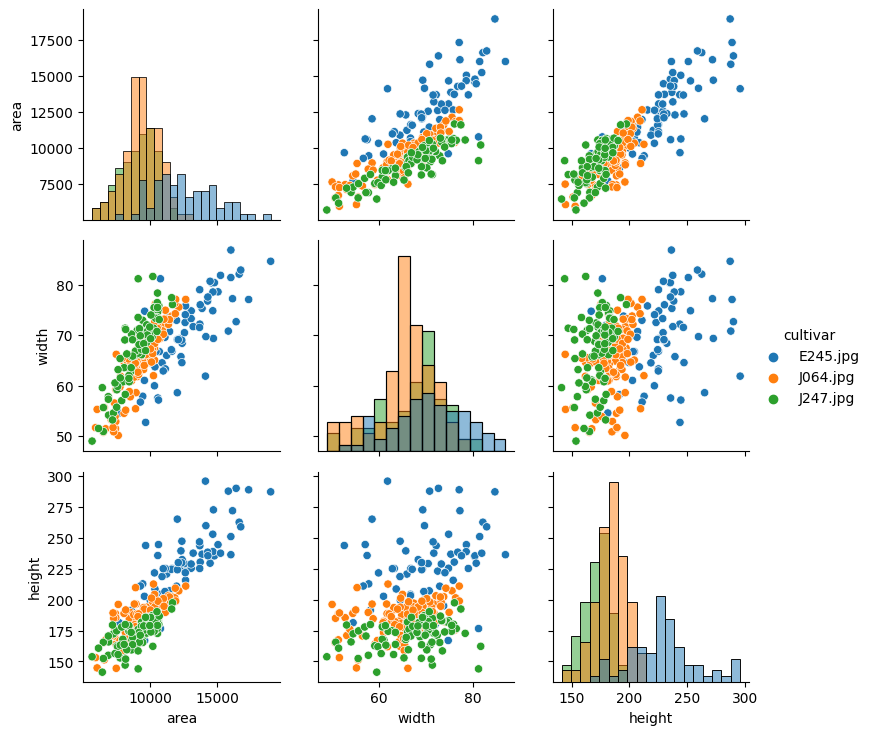

In [50]:
import seaborn as sns

# plot singe metrics
sns.boxplot(data=df, x="cultivar", y="area", hue="cultivar",dodge=False)
sns.swarmplot(data=df, x="cultivar",y="area", hue="cultivar", palette='dark:black', legend=False)
plt.show()

# plot multiple categories
g = sns.PairGrid(df, hue="cultivar")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()